In [2]:
import numpy as np
from sklearn import preprocessing, neighbors
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.layers import Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [3]:
path =r'D:\Py scripts\Sad Analysis\Own dataset'
targets = ['Solving', 'Relaxed']

In [4]:
targets

['Solving', 'Relaxed']

In [5]:
def divide_chunks(l, n): 
# looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

In [6]:
# get data file names
seg_dim = 7500
def segments(tag, seg_dim):
    filenames = glob.glob("{}\{}".format(path, tag) + "/*.csv")
    tag_df = pd.DataFrame()
    eeg_data = []
    for filename in filenames:
        tmp = pd.DataFrame()
        df = pd.read_csv(filename)
        segmented_eeg = list(divide_chunks(list(df['eegRawValue']), seg_dim))
        tmp['EEG'] = segmented_eeg
        tmp['tag_label'] = tag
        tmp['eeglen'] = tmp.EEG.apply(lambda x: len(x))
        tmp = tmp.query('eeglen == @seg_dim')
        eeg_data.append(tmp)
    #tag_df = pd.concat(eeg_data)
    return pd.concat(eeg_data)

In [7]:
train = []
for tag in targets:
    train.append(segments(tag, seg_dim))

In [8]:
train = pd.concat(train)
#train.to_csv("Recently_prepared_train2.csv", index = False)

In [9]:
train.columns

Index(['EEG', 'tag_label', 'eeglen'], dtype='object')

In [10]:
train.tag_label.value_counts()

Solving    108
Relaxed     89
Name: tag_label, dtype: int64

In [11]:
def replace(tag):
    if tag == 'Relaxed':
        return 0
    if tag == 'Solving':
        return 1
    if tag == 'Laugh':
        return 2
    # Relaxed -> 0

train['tag'] = train.tag_label.apply(replace)

In [12]:
X = np.array(list(train.EEG))
Y = train.tag.values
X = X.reshape(len(X), seg_dim, 1)
Y = pd.get_dummies(train.tag).values

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X, Y,test_size = 0.20)

In [56]:
print(device_lib.list_local_devices())

NameError: name 'device_lib' is not defined

In [16]:
model = Sequential()
model.add(LSTM(64, dropout_U = 0.1, dropout_W = 0.1))
model.add(Dense(500,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='Adam',metrics = ['accuracy'])

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.1, recurrent_dropout=0.1)`
  


In [17]:
#Fitting the NN model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train, y_train, epochs= 20, shuffle = True, callbacks=[es], 
                     validation_data=[X_test,y_test])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 157 samples, validate on 40 samples
Epoch 1/20
157/157 [==============================] - 64s 406ms/step - loss: 0.7044 - acc: 0.5096 - val_loss: 0.7465 - val_acc: 0.3750
Epoch 2/20
157/157 [==============================] - 60s 383ms/step - loss: 0.6830 - acc: 0.4904 - val_loss: 0.7083 - val_acc: 0.3500
Epoch 3/20
157/157 [==============================] - 61s 387ms/step - loss: 0.6571 - acc: 0.6115 - val_loss: 0.7106 - val_acc: 0.6500
Epoch 4/20
157/157 [==============================] - 61s 389ms/step - loss: 0.6986 - acc: 0.5732 - val_loss: 0.7119 - val_acc: 0.5000
Epoch 5/20
157/157 [==============================] - 64s 406ms/step - loss: 0.6636 - acc: 0.6178 - val_loss: 0.6881 - val_acc: 0.5000
Epoch 6/20
157/157 [==============================] - 63s 400ms/ste

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               16500     
_________________________________________________________________
dense_14 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 303       
Total params: 141,455
Trainable params: 141,455
Non-trainable params: 0
_________________________________________________________________


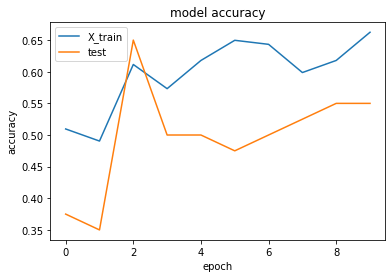

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['X_train', 'test'], loc='upper left')
plt.show()

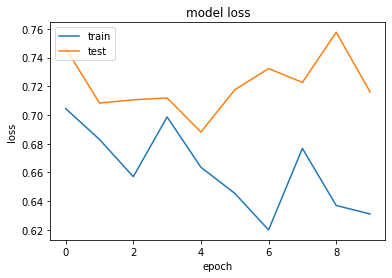

In [20]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
Y_p = model.predict_classes(X_test)

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print('Accuracy:', accuracy_score(y_test.argmax(axis=1), Y_p))
print('F1 score:', f1_score(y_test.argmax(axis=1), Y_p,average='weighted'))
print('Recall:', recall_score(y_test.argmax(axis=1), Y_p, average='weighted'))
print('Precision_score:', precision_score(y_test.argmax(axis=1), Y_p, average='weighted'))

Accuracy: 0.55
F1 score: 0.55
Recall: 0.55
Precision_score: 0.55


In [24]:
#binary
Y_p

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], dtype=int64)

In [25]:
y_test.argmax(axis=1)

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1], dtype=int64)

In [ ]:
#Relaxed -> 0
#Solving -> 1